In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
# import CelebA
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import sampler
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(device)

mps


In [4]:
# Setting random seed
torch.manual_seed(42)
BATCH_SIZE = 128

In [5]:
transform = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.ToTensor()
])

# Loading CelebA dataset
trainset = datasets.CelebA(root='./data', split='train',target_type='attr', download=True, transform=transform)
testset = datasets.CelebA(root='./data', split='test',target_type='attr', download=True, transform=transform)

# creating DataLoaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

1443490838it [00:21, 68230576.60it/s]
26721026it [00:00, 58534276.61it/s]
3424458it [00:00, 17870055.44it/s]
6082035it [00:00, 26864124.23it/s]
12156055it [00:00, 38721090.95it/s]
2836386it [00:00, 13233043.77it/s]


Files already downloaded and verified


In [6]:
# Let's check len and shape
print(len(trainset))
print(len(testset))

162770
19962


torch.Size([128, 3, 128, 128])
tensor(0.) tensor(1.)


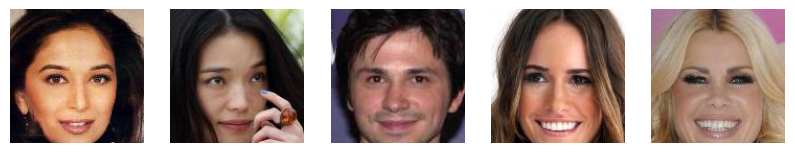

In [7]:
# Let's take the first batch of trainloader and check the shape, and the range of values, and plot the first 5 images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(images.min(), images.max())
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.axis('off')

# VAE Model Definition:

Given an input image of size (3, 128, 128), let's see how the dimensions change as the data flow through the model:

## Encoder:
1. **Conv2d Layer:** The first Conv2d layer transforms the input from (3, 128, 128) to (32, 64, 64). This is because it has 32 output channels, and with a kernel size of 4, stride of 2, and padding of 1, the spatial dimensions are halved.
2. **Conv2d Layer:** The second Conv2d layer transforms the input from (32, 64, 64) to (64, 32, 32). This is because it has 64 output channels, and with the same kernel size, stride, and padding, the spatial dimensions are again halved.
3. **Conv2d Layer:** The third Conv2d layer transforms the input from (64, 32, 32) to (128, 16, 16). This is because it has 128 output channels, and with the same kernel size, stride, and padding, the spatial dimensions are again halved.
4. **Conv2d Layer:** The fourth Conv2d layer transforms the input from (128, 16, 16) to (256, 8, 8). This is because it has 256 output channels, and with the same kernel size, stride, and padding, the spatial dimensions are again halved.

The output of the encoder is thus a tensor of shape (256, 8, 8). 

## Latent Space:
1. **Linear Layer (mu):** The first linear layer (self.fc_mu) flattens the output of the encoder and transforms it from (256*8*8) to (latent_dim), which in your case is 200.
2. **Linear Layer (logvar):** The second linear layer (self.fc_logvar) does the same but for the log variance.

The output of the latent space is thus two tensors each of shape (200,).

## Decoder:
1. **Linear Layer:** The linear layer (self.fc_decode) transforms the input from (200,) back to (256*8*8).
2. **ConvTranspose2d Layer:** The first ConvTranspose2d layer transforms the input from (256, 8, 8) to (128, 16, 16). This is because it has 128 output channels, and with the same kernel size, stride, and padding, the spatial dimensions are doubled.
3. **ConvTranspose2d Layer:** The second ConvTranspose2d layer transforms the input from (128, 16, 16) to (64, 32, 32). This is because it has 64 output channels, and with the same kernel size, stride, and padding, the spatial dimensions are again doubled.
4. **ConvTranspose2d Layer:** The third ConvTranspose2d layer transforms the input from (64, 32, 32) to (32, 64, 64). This is because it has 32 output channels, and with the same kernel size, stride, and padding, the spatial dimensions are again doubled.
5. **ConvTranspose2d Layer:** The fourth ConvTranspose2d layer transforms the input from (32, 64, 64) to (3, 128, 128). This is because it has 3 output channels, and with the same kernel size, stride, and padding, the spatial dimensions are again doubled.

The output of the decoder is thus a tensor of shape (3, 128, 128), which matches the original input size.

So, it seems your dimensions line up perfectly! Your encoder successfully compresses the input into the latent space, and your decoder successfully reconstructs the original input from the latent space.

In [8]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_channel, latent_dim):
        super(VAE, self).__init__()
        
        # Initialize input and latent dimensions
        self.input_channel = input_channel
        self.latent_dim = latent_dim
        
        # Define the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(self.input_channel, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        
        # Define the linear layers for mu and logvar
        self.fc_mu = nn.Linear(256*8*8, self.latent_dim)
        self.fc_logvar = nn.Linear(256*8*8, self.latent_dim)
        
        # Define the linear layer for decoding
        self.fc_decode = nn.Linear(self.latent_dim, 256*8*8)
        
        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, self.input_channel, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        # Encode the input image
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # flatten the output
        
        # Return the encoded mu and logvar
        return self.fc_mu(h), self.fc_logvar(h)

    def reparametrize(self, mu, logvar):
        # Reparametrize the encoded mu and logvar
        std = torch.exp(0.5*logvar)  # get the standard deviation
        eps = torch.randn_like(std)  # generate a random tensor with same size as std
        return mu + eps*std  # reparametrize
    
    def arithmetic(self, x1, x2):
        # Encode the input images
        mu1, logvar1 = self.encode(x1)
        z1 = self.reparametrize(mu1, logvar1)
        
        mu2, logvar2 = self.encode(x2)
        z2 = self.reparametrize(mu2, logvar2)
        
        # Perform arithmetic on z1 and z2
        z = z1 - z2  # for example
        
        # Decode the result
        return self.decode(z)

    def reconstruct(self, x):
        # Reconstruct the input image
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z)
    
    def generate(self, batch_size):
        # Generate random samples
        z = torch.randn((batch_size, self.latent_dim)).to(device)
        return self.decode(z)
    
    def decode(self, z):
        # Decode the input tensor
        z = self.fc_decode(z)
        z = z.view(z.size(0), 256, 8, 8)  # reshape the tensor
        return self.decoder(z)
    
    def forward(self, x):
        # Forward pass through the model
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
        
    def init_weights(self):
        # Initialize the weights of the model
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    

In [9]:
def vae_loss(recon_x, x, mu, logvar, BETA):
    MSE = F.mse_loss(recon_x.view(-1, 3*128*128), x.view(-1, 3*128*128), reduction='sum') / x.size(0)
    
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    loss = BETA * MSE + KLD
    
    return {'loss': loss, 'Reconstruction_Loss': MSE, 'KLD': KLD}

In [10]:
model = VAE(input_channel=3, latent_dim=100).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.init_weights()

In [11]:
def train(model, optimizer, train_loader, device, start_epoch, num_epochs, BETA, sample_size=8, log_wandb=True, checkpoint_path=None):
    
    if checkpoint_path is not None and log_wandb:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print('Loaded model from checkpoint')

    for epoch in tqdm(range(start_epoch, num_epochs)):
        model.train()
        total_loss = 0
        recon_loss = 0
        kld_loss = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_results = vae_loss(recon_batch, data, mu, logvar, BETA)
            loss = loss_results['loss']
            loss.backward()
            total_loss += loss.item()
            recon_loss += loss_results['Reconstruction_Loss'].item()
            kld_loss += loss_results['KLD'].item()
            optimizer.step()

            if batch_idx == 0:
                n = min(data.size(0), sample_size)
                comparison = torch.cat([data[:n], recon_batch.view(data.size(0), 3, 128, 128)[:n]])
                images = comparison.cpu()
                recon_images = recon_batch.view(data.size(0), 3, 128, 128).cpu()
                
        if log_wandb:
            wandb.log({
                'Total Loss': total_loss/len(train_loader),
                'Reconstruction Loss': recon_loss/len(train_loader),
                'KLD': kld_loss/len(train_loader),
                "original images": [wandb.Image(image) for image in images],
                "reconstructed images": [wandb.Image(image) for image in recon_images]
            })

        with torch.no_grad():
            latent_samples = torch.randn(sample_size, model.latent_dim).to(device)
            generated_images = model.decode(latent_samples)
            generated_images = generated_images.cpu()
        
        if log_wandb:
            wandb.log({
                "generated images": [wandb.Image(image) for image in generated_images]
            })

        if log_wandb:
            checkpoint_path = f'checkpoint_{epoch}.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, checkpoint_path)

            wandb.save(checkpoint_path)

        print(f'Epoch {epoch+1}, Total Loss: {total_loss/len(train_loader):.4f}, '
            f'Reconstruction Loss: {recon_loss/len(train_loader):.4f}, '
            f'KLD: {kld_loss/len(train_loader):.4f}')

    if log_wandb:
        wandb.finish()

    return total_loss / len(train_loader.dataset)


In [14]:
# start a new wandb run to track this script
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="CelebA_VAE_vanilla",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "VAE - Xavier init",
    "dataset": "CelebA",
    "epochs": 17-100,
    "batch_size": 128,
    "latent_dim": 200,
    "BatchNorm": True,
    "Dropout": True,
    "Normalize": False,
    "loss function": "MSE + KLD",
    "activation": "LeakyReLU",
    "notes": "First run of new VAE architecture"
    }
)

KLD,█▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Reconstruction Loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Total Loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
KLD,126.99043
Reconstruction Loss,324.14499
Total Loss,451.13542


In [15]:
train(
    model=model,
    optimizer=optimizer,
    train_loader=trainloader,
    device=device,
    start_epoch=0,
    num_epochs=50,
    BETA=1,
    sample_size=8,
    log_wandb=True,
    checkpoint_path="/Users/parkermoesta/Library/Mobile Documents/com~apple~CloudDocs/Generative Models/VAE/checkpoint_17.pth"
    
)

Loaded model from checkpoint


  2%|▏         | 1/50 [07:50<6:24:27, 470.77s/it]

Epoch 1, Total Loss: 449.8575, Reconstruction Loss: 322.8953, KLD: 126.9622


  4%|▍         | 2/50 [16:25<6:37:24, 496.76s/it]

Epoch 2, Total Loss: 448.7852, Reconstruction Loss: 321.8279, KLD: 126.9573


  6%|▌         | 3/50 [24:56<6:34:18, 503.36s/it]

Epoch 3, Total Loss: 447.2923, Reconstruction Loss: 320.3911, KLD: 126.9012


  8%|▊         | 4/50 [32:56<6:18:42, 493.97s/it]

Epoch 4, Total Loss: 445.9769, Reconstruction Loss: 319.1735, KLD: 126.8035


 10%|█         | 5/50 [41:39<6:18:24, 504.55s/it]

Epoch 5, Total Loss: 445.0300, Reconstruction Loss: 318.1518, KLD: 126.8782


 12%|█▏        | 6/50 [49:14<5:57:37, 487.68s/it]

Epoch 6, Total Loss: 444.2083, Reconstruction Loss: 317.3561, KLD: 126.8521


 14%|█▍        | 7/50 [56:45<5:40:54, 475.68s/it]

Epoch 7, Total Loss: 442.9028, Reconstruction Loss: 316.1093, KLD: 126.7935


 16%|█▌        | 8/50 [1:05:19<5:41:22, 487.68s/it]

Epoch 8, Total Loss: 442.6736, Reconstruction Loss: 315.8930, KLD: 126.7806


 18%|█▊        | 9/50 [1:13:34<5:34:49, 489.99s/it]

Epoch 9, Total Loss: 441.7521, Reconstruction Loss: 314.9895, KLD: 126.7626


 20%|██        | 10/50 [1:21:18<5:21:24, 482.12s/it]

Epoch 10, Total Loss: 441.3370, Reconstruction Loss: 314.5452, KLD: 126.7918


 22%|██▏       | 11/50 [1:29:04<5:10:12, 477.23s/it]

Epoch 11, Total Loss: 440.5450, Reconstruction Loss: 313.8015, KLD: 126.7435


 24%|██▍       | 12/50 [1:37:33<5:08:13, 486.66s/it]

Epoch 12, Total Loss: 439.2446, Reconstruction Loss: 312.5126, KLD: 126.7320


 26%|██▌       | 13/50 [1:45:30<4:58:23, 483.87s/it]

Epoch 13, Total Loss: 438.4724, Reconstruction Loss: 311.7172, KLD: 126.7552


 28%|██▊       | 14/50 [1:53:22<4:48:11, 480.32s/it]

Epoch 14, Total Loss: 438.8688, Reconstruction Loss: 312.1839, KLD: 126.6849


 30%|███       | 15/50 [2:01:34<4:42:12, 483.79s/it]

Epoch 15, Total Loss: 438.0747, Reconstruction Loss: 311.3500, KLD: 126.7247


 32%|███▏      | 16/50 [2:10:05<4:38:47, 492.00s/it]

Epoch 16, Total Loss: 437.1695, Reconstruction Loss: 310.4243, KLD: 126.7452


 34%|███▍      | 17/50 [2:17:53<4:26:41, 484.89s/it]

Epoch 17, Total Loss: 437.1851, Reconstruction Loss: 310.4556, KLD: 126.7294


 36%|███▌      | 18/50 [2:25:39<4:15:35, 479.23s/it]

Epoch 18, Total Loss: 436.3634, Reconstruction Loss: 309.5939, KLD: 126.7696


 38%|███▊      | 19/50 [2:33:32<4:06:34, 477.25s/it]

Epoch 19, Total Loss: 435.9585, Reconstruction Loss: 309.2254, KLD: 126.7331


 40%|████      | 20/50 [2:41:52<4:02:03, 484.12s/it]

Epoch 20, Total Loss: 435.2486, Reconstruction Loss: 308.5097, KLD: 126.7388


 42%|████▏     | 21/50 [2:49:44<3:52:08, 480.30s/it]

Epoch 21, Total Loss: 435.0532, Reconstruction Loss: 308.3413, KLD: 126.7119


 44%|████▍     | 22/50 [2:57:20<3:40:44, 473.03s/it]

Epoch 22, Total Loss: 434.5613, Reconstruction Loss: 307.7882, KLD: 126.7731


 46%|████▌     | 23/50 [3:06:11<3:40:46, 490.60s/it]

Epoch 23, Total Loss: 434.4108, Reconstruction Loss: 307.6287, KLD: 126.7821


 48%|████▊     | 24/50 [3:13:30<3:25:49, 474.98s/it]

Epoch 24, Total Loss: 433.7019, Reconstruction Loss: 306.9674, KLD: 126.7345


 50%|█████     | 25/50 [3:21:21<3:17:25, 473.83s/it]

Epoch 25, Total Loss: 434.0480, Reconstruction Loss: 307.3564, KLD: 126.6915


 52%|█████▏    | 26/50 [3:28:45<3:05:59, 464.99s/it]

Epoch 26, Total Loss: 433.3040, Reconstruction Loss: 306.5767, KLD: 126.7273


 54%|█████▍    | 27/50 [3:36:36<2:58:57, 466.85s/it]

Epoch 27, Total Loss: 433.1787, Reconstruction Loss: 306.4641, KLD: 126.7146


 56%|█████▌    | 28/50 [3:43:57<2:48:19, 459.08s/it]

Epoch 28, Total Loss: 432.5248, Reconstruction Loss: 305.8171, KLD: 126.7076


 58%|█████▊    | 29/50 [3:51:21<2:39:03, 454.47s/it]

Epoch 29, Total Loss: 432.5111, Reconstruction Loss: 305.8075, KLD: 126.7036


 60%|██████    | 30/50 [3:58:55<2:31:25, 454.30s/it]

Epoch 30, Total Loss: 431.7500, Reconstruction Loss: 305.0273, KLD: 126.7228


 62%|██████▏   | 31/50 [4:06:23<2:23:16, 452.46s/it]

Epoch 31, Total Loss: 431.7416, Reconstruction Loss: 305.0120, KLD: 126.7297


 64%|██████▍   | 32/50 [4:13:40<2:14:18, 447.70s/it]

Epoch 32, Total Loss: 431.6562, Reconstruction Loss: 304.9480, KLD: 126.7083


 66%|██████▌   | 33/50 [4:21:01<2:06:15, 445.62s/it]

Epoch 33, Total Loss: 431.4300, Reconstruction Loss: 304.6864, KLD: 126.7436


 68%|██████▊   | 34/50 [4:28:25<1:58:45, 445.37s/it]

Epoch 34, Total Loss: 430.8033, Reconstruction Loss: 304.0224, KLD: 126.7809


 70%|███████   | 35/50 [4:35:47<1:51:03, 444.22s/it]

Epoch 35, Total Loss: 431.0926, Reconstruction Loss: 304.3275, KLD: 126.7651


 72%|███████▏  | 36/50 [4:43:09<1:43:30, 443.59s/it]

Epoch 36, Total Loss: 430.1292, Reconstruction Loss: 303.3569, KLD: 126.7723


 74%|███████▍  | 37/50 [4:50:31<1:35:59, 443.01s/it]

Epoch 37, Total Loss: 430.0162, Reconstruction Loss: 303.2343, KLD: 126.7820


 76%|███████▌  | 38/50 [4:57:51<1:28:27, 442.26s/it]

Epoch 38, Total Loss: 430.0414, Reconstruction Loss: 303.3287, KLD: 126.7127


 78%|███████▊  | 39/50 [5:05:18<1:21:19, 443.62s/it]

Epoch 39, Total Loss: 429.8159, Reconstruction Loss: 303.0744, KLD: 126.7414


 80%|████████  | 40/50 [5:12:37<1:13:41, 442.14s/it]

Epoch 40, Total Loss: 429.4853, Reconstruction Loss: 302.7245, KLD: 126.7607


 82%|████████▏ | 41/50 [5:19:59<1:06:20, 442.23s/it]

Epoch 41, Total Loss: 429.4890, Reconstruction Loss: 302.7167, KLD: 126.7723


 84%|████████▍ | 42/50 [5:27:17<58:47, 440.94s/it]  

Epoch 42, Total Loss: 429.4549, Reconstruction Loss: 302.6746, KLD: 126.7803


 86%|████████▌ | 43/50 [5:35:37<53:30, 458.70s/it]

Epoch 43, Total Loss: 429.0180, Reconstruction Loss: 302.2123, KLD: 126.8057


 88%|████████▊ | 44/50 [5:42:58<45:19, 453.20s/it]

Epoch 44, Total Loss: 428.6460, Reconstruction Loss: 301.8445, KLD: 126.8015


 90%|█████████ | 45/50 [5:50:18<37:26, 449.30s/it]

Epoch 45, Total Loss: 428.4318, Reconstruction Loss: 301.6250, KLD: 126.8068


 92%|█████████▏| 46/50 [5:57:33<29:40, 445.12s/it]

Epoch 46, Total Loss: 428.5271, Reconstruction Loss: 301.7325, KLD: 126.7945


 94%|█████████▍| 47/50 [6:05:04<22:20, 446.96s/it]

Epoch 47, Total Loss: 428.0659, Reconstruction Loss: 301.2582, KLD: 126.8077


 96%|█████████▌| 48/50 [6:12:27<14:51, 445.74s/it]

Epoch 48, Total Loss: 428.0796, Reconstruction Loss: 301.2589, KLD: 126.8207


 98%|█████████▊| 49/50 [6:19:48<07:24, 444.26s/it]

Epoch 49, Total Loss: 427.9055, Reconstruction Loss: 301.0426, KLD: 126.8629


100%|██████████| 50/50 [6:27:08<00:00, 464.58s/it]

Epoch 50, Total Loss: 427.9026, Reconstruction Loss: 301.0930, KLD: 126.8096


KLD,██▆▄▅▄▃▃▂▂▃▁▃▂▃▂▂▃▃▂▂▂▂▁▂▂▂▃▃▃▂▂▃▃▄▄▄▄▄▄
Reconstruction Loss,██▇▇▆▆▆▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Total Loss,██▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
KLD,126.80961
Reconstruction Loss,301.09301
Total Loss,427.90262


3.3439339409195585

# Visualizations

In [16]:
def plot_latent_distribution(model, dataloader, device, num_variables=50):
    model.eval()
    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            data = data.to(device)
            mu, logvar = model.encode(data)
            z = model.reparametrize(mu, logvar)
            break  # only use one batch
    
    z = z.detach().cpu().numpy()  # convert to numpy array
    fig, axs = plt.subplots(5, 10, figsize=(20, 10))
    
    for i, ax in enumerate(axs.flatten()):
        if i >= num_variables:
            break
        ax.hist(z[:, i], bins=20, density=True)
        ax.set_title(f'Latent var {i+1}')
    
    plt.tight_layout()
    plt.show()

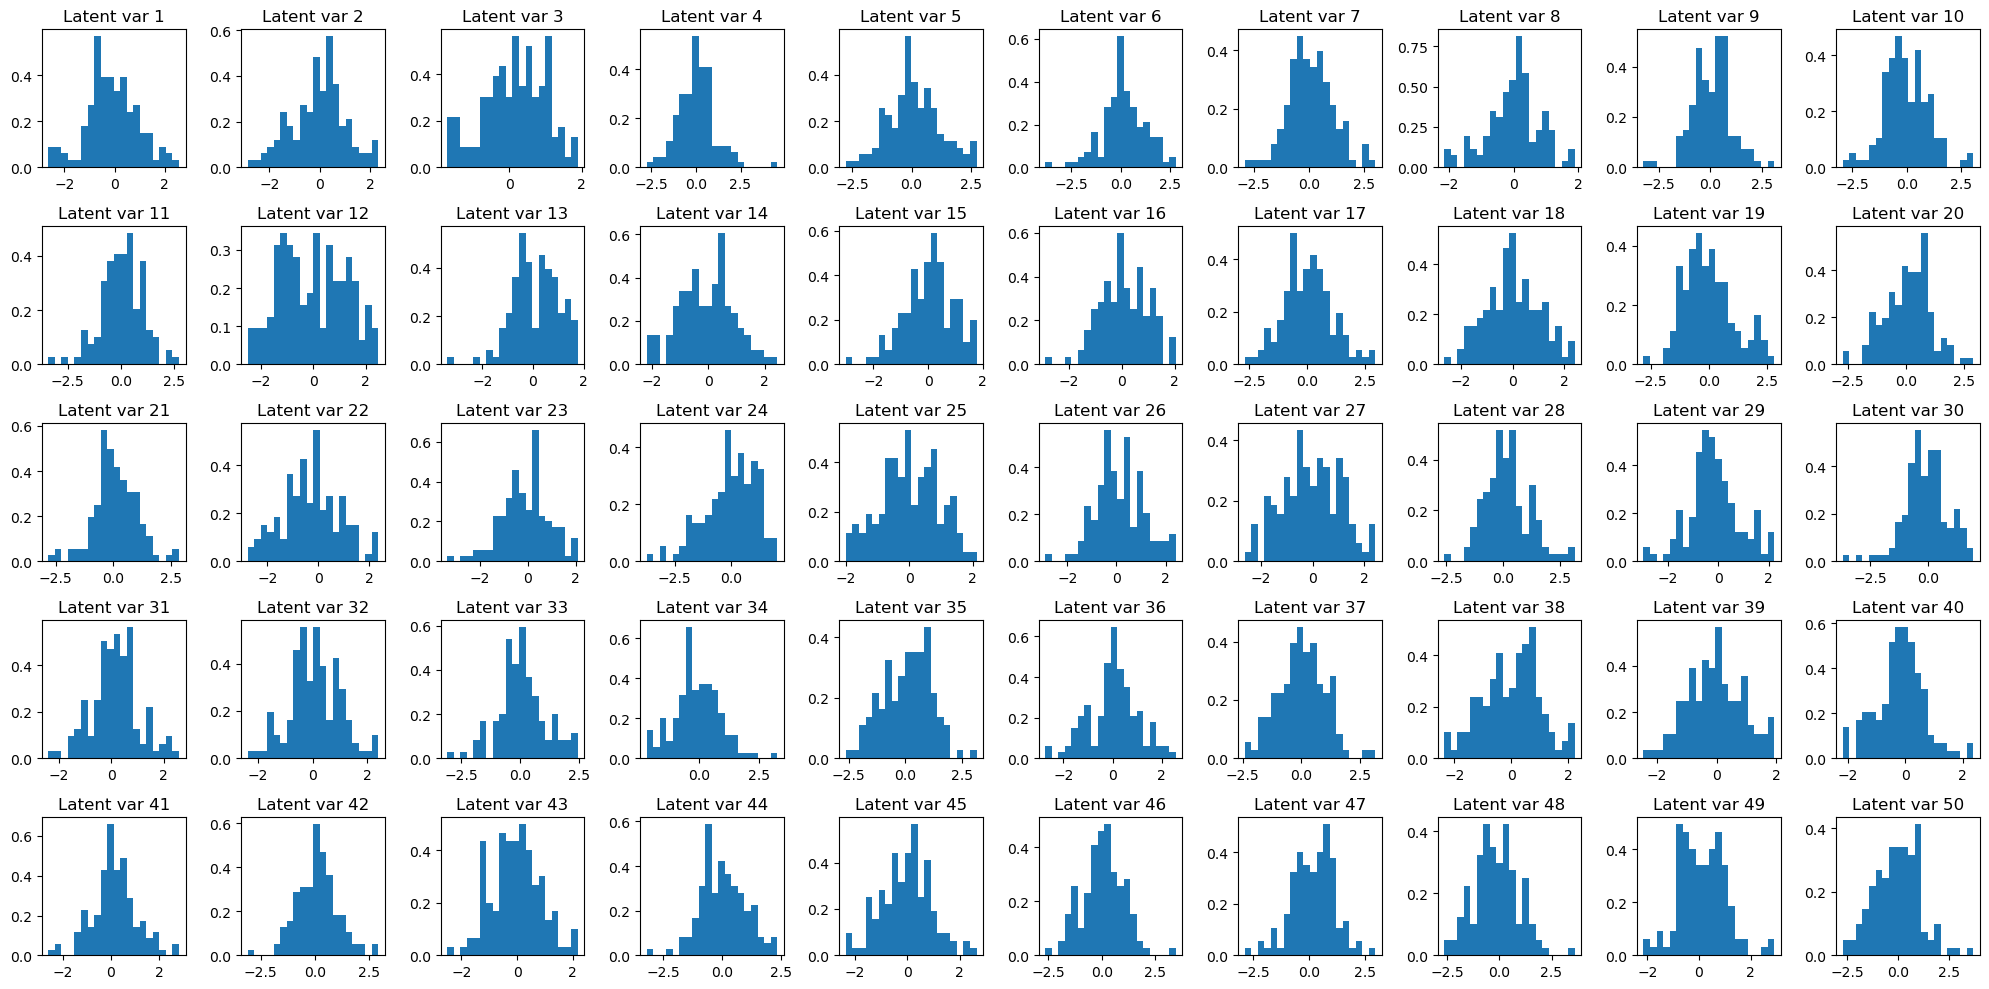

In [18]:
plot_latent_distribution(model, trainloader, device, num_variables=50)

## Vis v2

Grabbing random face...
Morphing faces in latent space...


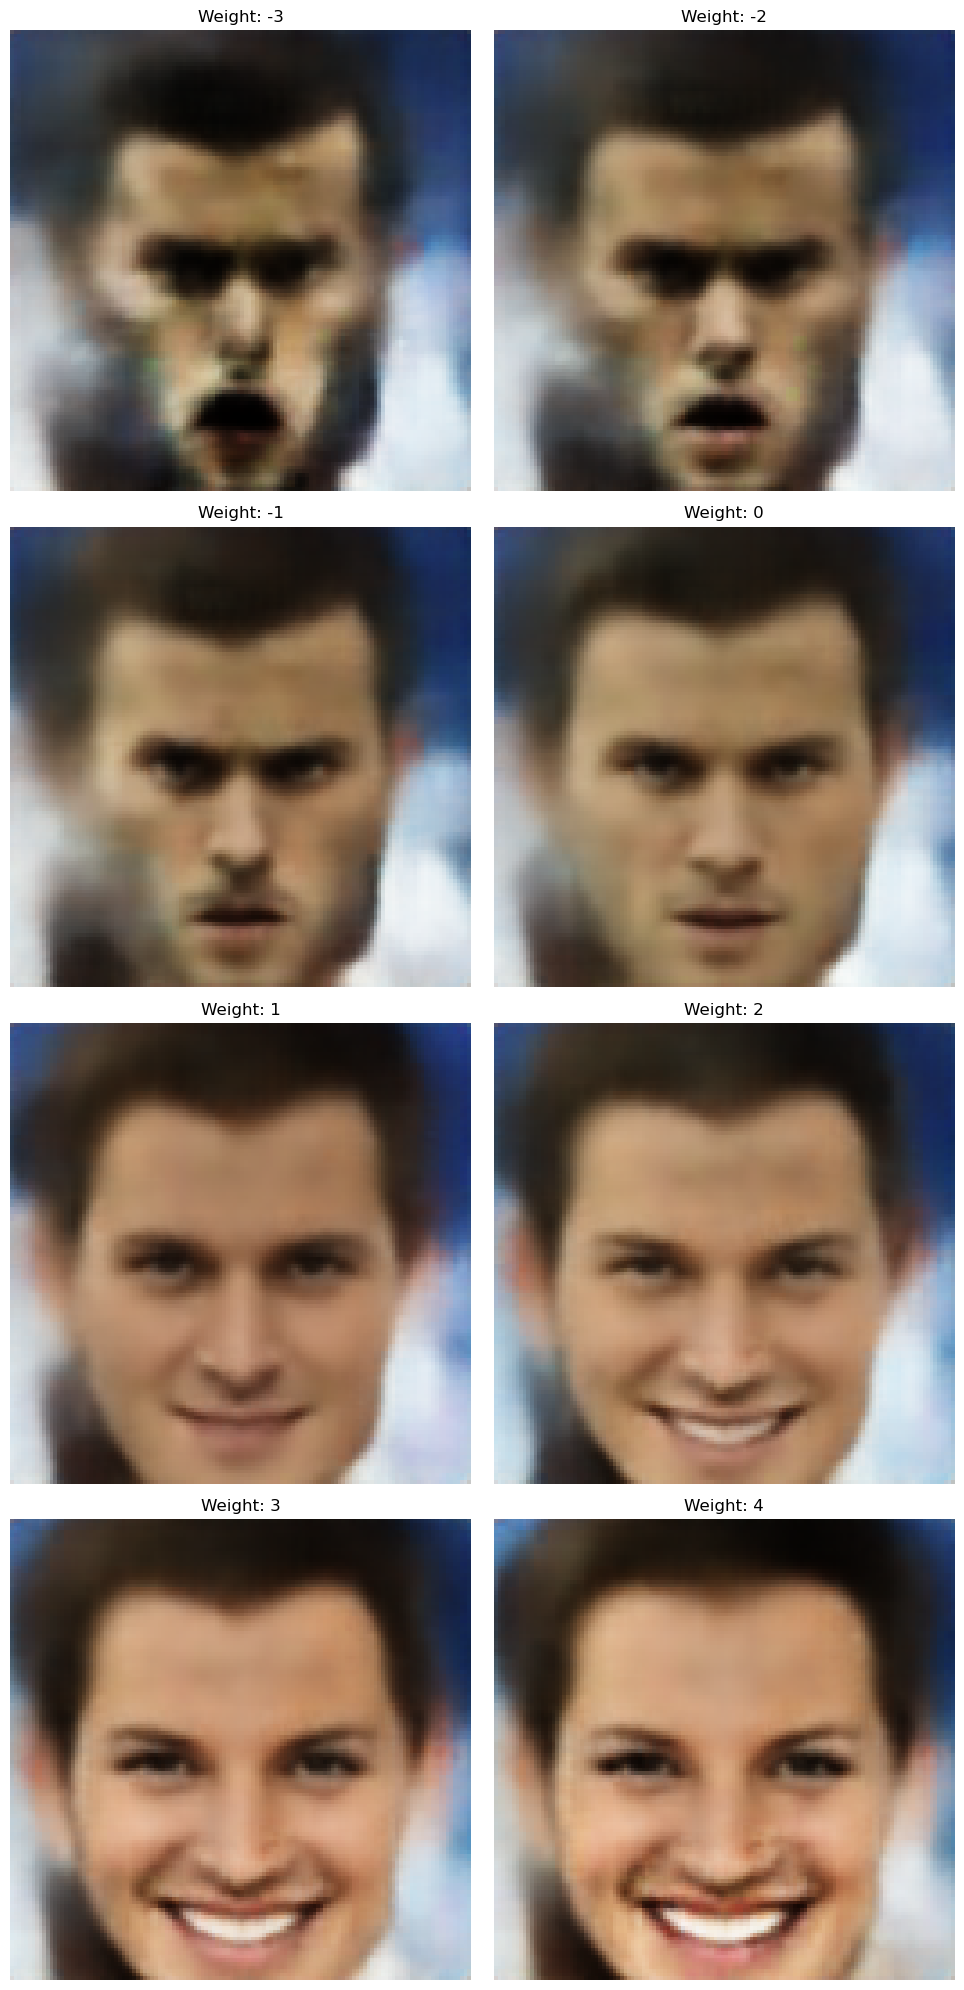

In [32]:
import random
import numpy as np

def make_smile(model, dataloader, device, index, weights, smiling=True, example_image=None, random_example=False):
    model.eval()
    z_smiling = []
    z_not_smiling = []
    print("Collecting smiling and non-smiling faces...")

    with torch.no_grad():
        for i, (data, attrs) in enumerate(dataloader):
            data = data.to(device)
            mu, logvar = model.encode(data)
            z = model.reparametrize(mu, logvar)
            z = z.detach().cpu().numpy()  # convert to numpy array
            attrs = attrs[:, index]  # get the attribute for smiling

            z_smiling.extend(z[attrs == 1])
            z_not_smiling.extend(z[attrs == 0])

    z_smiling = np.array(z_smiling)
    z_not_smiling = np.array(z_not_smiling)

    z_smiling_avg = np.mean(z_smiling, axis=0)
    z_not_smiling_avg = np.mean(z_not_smiling, axis=0)

    difference = z_smiling_avg - z_not_smiling_avg

    fig, axs = plt.subplots(4, 2, figsize=(10, 20))

    if random_example:
        print("Grabbing random face...")
        example_image, _ = next(iter(dataloader))  # get a batch of images
        example_image = example_image[random.randint(0, example_image.size(0) - 1)]  # take a random image in the batch

    print("Morphing faces in latent space...")
    for i, weight in enumerate(weights):
        if example_image is not None:
            mu, logvar = model.encode(example_image.unsqueeze(0).to(device))
            z_example = model.reparametrize(mu, logvar)
            z_example = z_example.detach().cpu().numpy()
            z_new = z_example + weight * difference if smiling else z_example - weight * difference
        else:
            z_new = z_smiling_avg + weight * difference if smiling else z_not_smiling_avg - weight * difference
        z_new = torch.from_numpy(z_new).float().unsqueeze(0).to(device)
        new_img = model.decode(z_new).view(3, 128, 128).detach().cpu()

        axs[i // 2, i % 2].imshow(np.transpose(new_img.numpy(), (1, 2, 0)))
        axs[i // 2, i % 2].set_title(f'Weight: {weight}')
        axs[i // 2, i % 2].axis('off')

    plt.tight_layout()
    plt.show()

make_smile(model, trainloader, device, index=31, weights=[-3, -2, -1, 0, 1, 2, 3,4], smiling=True, random_example=True)